In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

In [2]:
%%time
file_path = '../data/cleaned/cleaned_taxi_data.csv'
chunksize = 10**6

with pd.read_csv(file_path, chunksize=chunksize) as reader:
    taxi_df = pd.concat([chunk for chunk in reader])

taxi_df.head()

CPU times: total: 14.6 s
Wall time: 14.6 s


,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,MA (m/s^2),gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.706207,-9.270792,...,9.503762,-0.028965,-0.032652,0.015390,0.046282,2.0,0.03,0.822436,4.0,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.416705,-9.548032,...,9.830320,-0.022413,0.005049,-0.025753,0.034511,3.0,0.05,0.822436,4.0,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.346924,-9.532629,...,9.614707,0.014962,-0.050033,0.025118,0.057949,9.0,0.15,0.822436,4.0,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.600986,-9.452029,...,9.713747,0.004548,-0.011713,-0.004078,0.013210,11.0,0.18,0.822436,4.0,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.597546,-9.863403,...,10.022063,-0.000401,0.000315,-0.009830,0.009843,12.0,0.20,0.822436,4.0,0


In [3]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 21 columns):
 #   Column           Dtype  
---  ------           -----  
 0   booking_id       int64  
 1   name             object 
 2   driver_age       int64  
 3   gender           object 
 4   car_model        object 
 5   car_make_year    int64  
 6   accuracy         float64
 7   direction        object 
 8   acceleration_x   float64
 9   acceleration_y   float64
 10  acceleration_z   float64
 11  MA (m/s^2)       float64
 12  gyro_x           float64
 13  gyro_y           float64
 14  gyro_z           float64
 15  MAV (rad/s)      float64
 16  second           float64
 17  duration (mins)  float64
 18  speed (km/h)     float64
 19  rating           float64
 20  safety_label     int64  
dtypes: float64(13), int64(4), object(4)
memory usage: 1.2+ GB


## What are the indicators of a dangerous taxi ride?

In [4]:
# group by booking id and get mean values of all numeric columns
mean_numeric_by_booking = taxi_df.groupby('booking_id').mean().reset_index()
mean_numeric_by_booking.head()

,booking_id,driver_age,car_make_year,accuracy,acceleration_x,acceleration_y,acceleration_z,MA (m/s^2),gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),rating,safety_label
0,0,48.0,2013.0,9.910314,-0.704380,-9.602988,-1.531959,9.866200,0.004497,-0.001085,-0.001678,0.100083,925.852423,15.430903,32.583654,4.0,0.0
1,1,44.0,2011.0,3.719071,-0.508804,9.537349,-2.203838,9.878065,-0.000880,-0.004400,0.002048,0.067923,576.813131,9.613662,27.152307,3.5,1.0
2,2,39.0,2011.0,3.803753,0.274632,9.767902,0.053183,9.838854,-0.005815,-0.009442,0.004268,0.090791,313.578313,5.226265,10.155924,4.0,1.0
3,4,31.0,2008.0,10.000000,-0.377564,-9.378070,-2.651844,9.797977,-0.023974,0.024241,0.003029,0.109850,543.901210,9.065040,21.937178,3.5,1.0
4,6,48.0,2005.0,4.614597,0.553689,9.515172,2.322950,9.890313,0.006661,-0.010713,0.001617,0.093385,538.218631,8.970304,16.801649,4.5,0.0


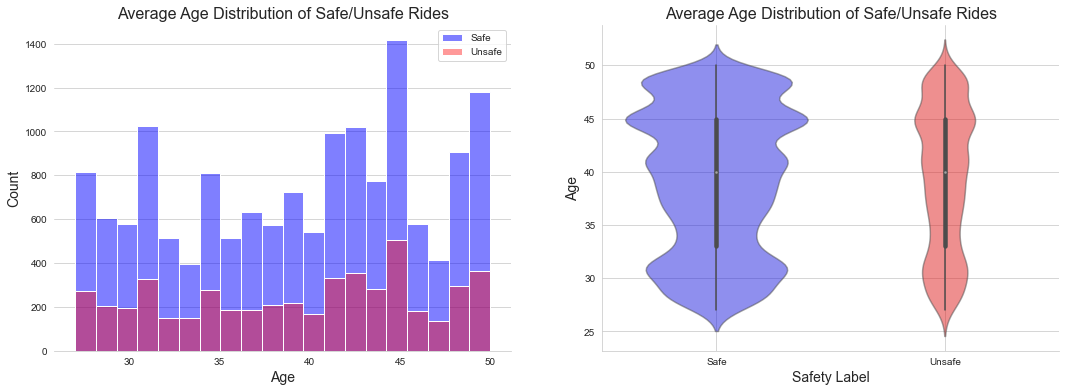

In [5]:
# does age have any effect on the trip safety? can we assume younger people are more reckless?

# average age of drivers with safe/unsafe driving
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# histogram
sns.histplot(mean_numeric_by_booking[mean_numeric_by_booking['safety_label'] == 0]['driver_age'], bins=20, color='blue', alpha=0.5, label='Safe', ax=ax[0])
sns.histplot(mean_numeric_by_booking[mean_numeric_by_booking['safety_label'] == 1]['driver_age'], bins=20, color='red', alpha=0.4, label='Unsafe', ax=ax[0])

ax[0].set_title('Average Age Distribution of Safe/Unsafe Rides', fontsize=16)
ax[0].set_xlabel('Age', fontsize=14)
ax[0].set_ylabel('Count', fontsize=14)
ax[0].grid(axis='x')
ax[0].legend()

# violinplot of both safe and unsafe rides
g = sns.violinplot(x='safety_label', y='driver_age', data=mean_numeric_by_booking, scale='count', linewidth=1.5, palette=['blue', 'red'], ax=ax[1])

# set alpha of violinplots to 0.5
for pc in g.collections:
    pc.set_alpha(0.5)

ax[1].set_title('Average Age Distribution of Safe/Unsafe Rides', fontsize=16)
ax[1].set_xlabel('Safety Label', fontsize=14)
ax[1].set_ylabel('Age', fontsize=14)
ax[1].grid(axis='x')
ax[1].set_xticklabels(['Safe', 'Unsafe'])

sns.despine(right=True, top=True, left=True, bottom=False, ax=ax[0])
sns.despine(right=True, top=True, left=False, bottom=False, ax=ax[1])
plt.show()

## Why do trips become dangerous?

## Which periods do rides become dangerous?

## Are rides with higher rating necessarily safer?

## Which drivers are at most risks of danger?